In [10]:
#trying to align the hst imgs in this folder with https://astroalign.readthedocs.io/en/latest/index.html

import astroalign as aa
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(seed=12)
aa.__version__

'2.4.1'

In [2]:
#just to check python version - should be 3.7.4
from platform import python_version
print(python_version())

#importing libraries
from astropy.io import fits
from astropy.convolution import convolve, Gaussian2DKernel, Box2DKernel
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from reproject import reproject_exact  #a package that can be added to astropy using anaconda or pip (see their docs pg)
from reproject import reproject_interp

import glob
import itertools
import matplotlib 
# matplotlib.use('Agg') #invokved b/c just plain matplotlib was insufficient
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

3.8.5


In [4]:
# #finding the path to every fits images in a directory
def im_name_finder(path, file_type):
    #Using glob (it's a unix command similar to ls)
    #WARNING: using recursive=True...depending how many images you use this could be very slow, it's recommended not to have too many subfolders
    #if needed, some example code is commented towards the latter half of this code that could help make an alternative
    all_names = glob.glob(path, recursive=True)

    #IMPORTANT: Using "fit" here because it is inclusive of both fits and FIT...some files end in "FIT" and need to be included
    #using s.lower() include uppercase names
    im_names = [s for s in all_names if 'fit' in s.lower()]

    return im_names


# In[27]:

#setting up a new fits file to be saved and viewed in DS9
#primarily to save the image we reprojected, but can also be used to save the convolved images
def fits_saver(array, wcs_header, name, save_path):
    '''
    array is a 2d array of data - could be from reprojecting one image onto another or from convolution
    wcs_header is a header containing the wcs coords of the image that we projected onto or of the orig image (if from the convolution)
    name is the path to some image you're using. It will get string split at the / character, and the func only takes the last element of that splitting
    save_path is the folder you want to save to...recommended to also add something to the start of the images names to make it clear what you did to them (e.g. 'Regridded/regrid_')
    '''

    #creating a new file and adding the reprojected array of data as well as the WCS that we projected onto
#     if [badkey for badkey in wcs_header if badkey == 'ORGNAME'] == []:
#         hdu_new = fits.PrimaryHDU(array, header=wcs_header)
#     else:
#         wcs_header = wcs_header.remove('ORGNAME')
#         hdu_new = fits.PrimaryHDU(array, header=wcs_header)

    hdu_new = fits.PrimaryHDU(array, header=wcs_header)
    hdul = fits.HDUList([hdu_new])
    
    #saving the file
    if name.find('FIT') == -1: #needed if file end incorrect
        new_filename = name.split('/')[-1]  #grabs the file name we were using from before
        hdul.writeto(save_path+new_filename, overwrite=True, output_verify='ignore')     
    else:
        name_fixfit = name[:-3] + 'fits'
        new_filename = name_fixfit.split('/')[-1]  #grabs the file name we were using from before
        hdul.writeto(save_path+new_filename, overwrite=True, output_verify='ignore')
        
    return (save_path+new_filename)


#our plotting function
def implot(data, w, wcscond, vmax_p):
    fig = plt.figure()
    
    if  wcscond == True:
        fig.add_subplot(111, projection=w)
    else:
        fig.add_subplot(111)
    
    #for christmas turn on GnRd
    #plt.cm.get_cmap('Blues', 6) is another option
    #can also use RdBu...
    #otherwise just use plt.cm.viridis b/c it works
    plt.imshow(data, origin='lower', cmap=plt.cm.viridis, vmin =0, vmax=vmax_p)
    plt.xlabel('RA')
    plt.ylabel('Dec')
    
    #plt.close() #only if doing on inanna

In [5]:
#loading data for hh6
path = 'hh6/*'
# path = 'hh711/*'

files_data = [i.replace('\\', '/') for i in im_name_finder(path, 'fits')]
hdu_list = [fits.open(i) for i in files_data]


hdu_pix_list = []
hdu_pixtorad_list = []
hdu_fnu_list = []
hdu_flam_list = []
hdu_bw_list = []
hdu_data_list = []
hdu_header_list = []

for count, hdu in enumerate(hdu_list):
        hdu_pix_list.append(hdu[0].header['D001SCAL'])  #D001SCAL is the keyword for Hubble images, in sr
        hdu_pixtorad_list.append(hdu_pix_list[count] / 206265.)
        # hdu_fnu_list.append(hdu[0].header['PHOTFNU'])
        hdu_flam_list.append(hdu[0].header['PHOTFLAM'])
        hdu_bw_list.append(hdu[0].header['PHOTBW'])

        #reading in data for general use  and header for wcs
        #converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above
        hdu_data_list.append(hdu[1].data * hdu[0].header['PHOTFLAM'] * hdu[0].header['PHOTBW'])
        print(hdu[0].header['PHOTPLAM']/1e-6*1e-10, hdu[0].header['PHOTFLAM'], hdu[0].header['PHOTBW'])
        hdu_header_list.append(hdu[1].header)

1.6403508000000002 2.8256999e-19 700.06543
1.2584887000000002 4.9671002e-19 339.31592
1.2831845 4.3479999e-19 357.43805


In [14]:
#attempting alignment
source = hdu_data_list[0] #should be 1.26 mic
target = hdu_data_list[1] #should be 1.64 mic
registered_image, footprint = aa.register(target, source) #first is source, second is target (chosen arbitrarily)

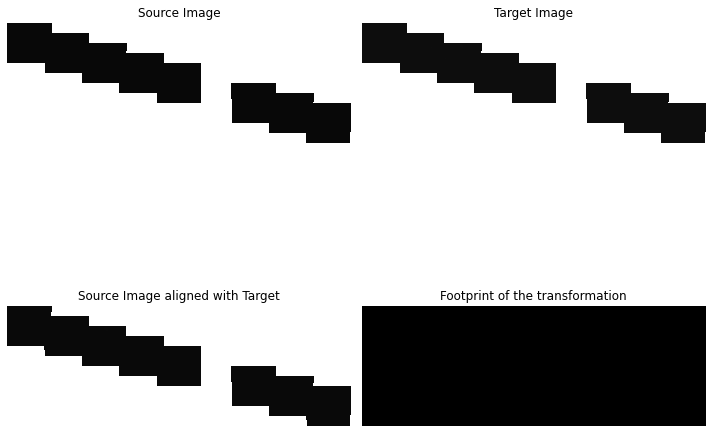

In [15]:
#plotting

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(source, cmap='gray', interpolation='none', origin='lower')
axes[0, 0].axis('off')
axes[0, 0].set_title("Source Image")

axes[0, 1].imshow(target, cmap='gray', interpolation='none', origin='lower')
axes[0, 1].axis('off')
axes[0, 1].set_title("Target Image")

axes[1, 0].imshow(registered_image, cmap='gray', interpolation='none', origin='lower')
axes[1, 0].axis('off')
axes[1, 0].set_title("Source Image aligned with Target")

axes[1, 1].imshow(footprint, cmap='gray', interpolation='none', origin='lower')
axes[1, 1].axis('off')
axes[1, 1].set_title("Footprint of the transformation")

axes[1, 0].axis('off')

plt.tight_layout()

In [ ]:
#had some sort of fits_saver command here...I think this was for the aligned images...they were not aligned 

In [35]:
#next, based on looking at images by hand, from 126 to 164, the pixels on 164 are actually at a lower RA and Dec relative to 126
#so we need 164 center shifted down to a position that is by 4476.56-4469.5554 and 1688.88-1685.8796 (based on star ASR 24)
#some other stars we could use: ASR 28, ASR 29

print(files_data) #so the first one is 164, the second one is 126
print(hdu_data_list[1].shape, hdu_data_list[0].shape)

# print(hdu_header_list[1]['CRPIX1'], hdu_header_list[1]['CRPIX2'])
# print(hdu_header_list[1]['NAXIS1'], hdu_header_list[1]['NAXIS2'])
# print(hdu_header_list[0]['CRPIX1'], hdu_header_list[0]['CRPIX2'])
# print(hdu_header_list[0]['NAXIS1'], hdu_header_list[0]['NAXIS2'])

w_126 = WCS(hdu_header_list[1]) #wcs of img we shift to, 126 here
print(w_126)

#shifting wcs of 164 img by diff btwn ASR 24 pos in 126 and 164 imgs while using DS9
ra_shift = 9 # 4476.56-4469.5554 about = 7
dec_shift = 2 # 1688.88-1685.8796 about = 3
center_164_shifted = (hdu_header_list[0]['CRPIX1']-ra_shift, hdu_header_list[0]['CRPIX2']-dec_shift)
size = (hdu_header_list[0]['NAXIS2'], hdu_header_list[0]['NAXIS1'])

cutout = Cutout2D(hdu_data_list[0], center_164_shifted, size, wcs = w_126)
datacut = cutout.data

# #fixing wcs
wcscut = cutout.wcs 
print(wcscut)
wcs_header_cut = wcscut.to_header()

# print(datacut.shape)

fits_saver(datacut, wcs_header_cut, '164_translated.fits', 'hh6/')

['hh6/idn107010_drz.fits', 'hh6/idn115010_drz.fits', 'hh6/idn123010_drz.fits']
(2894, 8314) (2894, 8314)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 52.30879868954485  31.29524785918432  
CRPIX : 4157.0  1447.0  
CD1_1 CD1_2  : -9.2204215734986e-06  -3.4411110235378e-05  
CD2_1 CD2_2  : -3.4411110235378e-05  9.22042157349863e-06  
NAXIS : 8314  2894
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 52.30879868954485  31.29524785918432  
CRPIX : 4157.0  1447.0  
CD1_1 CD1_2  : -9.2204215734986e-06  -3.4411110235378e-05  
CD2_1 CD2_2  : -3.4411110235378e-05  9.22042157349863e-06  
NAXIS : 8305  2892


'hh6/164_translated.fits'

In [27]:
#trying the reverse shift...

w_164 = WCS(hdu_header_list[0]) #wcs of img we shift to, 126 here

#shifting wcs of 164 img by diff btwn ASR 24 pos in 126 and 164 imgs while using DS9
ra_shift = 4476.56-4469.5554
dec_shift = 1688.88-1685.8796
center_126_shifted = (hdu_header_list[1]['CRPIX1']+ra_shift, hdu_header_list[1]['CRPIX2']+dec_shift)
size = (hdu_header_list[1]['NAXIS2'], hdu_header_list[1]['NAXIS1'])

cutout = Cutout2D(hdu_data_list[1], center_126_shifted, size, wcs = w_164)
datacut = cutout.data

# #fixing wcs
wcscut = cutout.wcs 
wcs_header_cut = wcscut.to_header()

# print(datacut.shape)

fits_saver(datacut, wcs_header_cut, '126_translated.fits', 'hh6/')

'hh6/126_translated.fits'